In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
%matplotlib notebook
import time
import datetime

#Save experiment begin date
current_time = datetime.datetime.now()
print("Current_date: "+str(current_time))
current_time = "".join(current_time.strftime("%x").split('/'))


#Import usual things required for graph nets
import numpy as np
import pandas as pd
import networkx as nx
import sonnet as snt
import tensorflow as tf
import os
import sys
from matplotlib import pyplot as plt
from matplotlib import animation
import seaborn as sns

#Import graph nets
from graph_nets import blocks
from graph_nets import utils_tf
from graph_nets import utils_np
from graph_nets.demos import models

#Path to the scripts shared troughout phases
parent_path=os.path.abspath('..')
path_common =  '/'.join(parent_path.split('/')[:-1])
path_common = os.path.join(path_common,'Common','Scripts')
#Check if path exists
if(not os.path.exists(path_common)):
    print('The path: '+ os.path.exists(path_common)+' is not found!')
#Add shared scripts to our current paths for importing
sys.path.insert(0, path_common)

#Path to saved models and trajectories
path_saves = os.path.join(parent_path,'Two_ended_chain','Saves')

#Path to plots
path_plots = os.path.join(parent_path,'Two_ended_chain','Plots')

#Path to animations
path_animations = os.path.join(parent_path,'Two_ended_chain','Animations')

#Change here
num_training_iterations = 3000
batch_size_tr = 256
batch_size_ge = 100
num_time_steps = 50

desc = "ntr="+str(num_training_iterations)
desc = desc +"_btr="+str(batch_size_tr)
desc = desc +"_bge="+str(batch_size_ge)
desc = desc +"date="+str(current_time)

#Set seed to 1 for reproduceability
SEED = 1
np.random.seed(SEED)
tf.set_random_seed(SEED)

Current_date: 2020-02-06 16:15:17.318776

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.



# Import functions

In [2]:
#Import functions for simulating
from Simulation_Functions_simple import SpringMassSimulator, generate_trajectory, roll_out_physics
#Import functions for creating graph
from Graph_creator_functions import chain_graph_simple
#Import visualisation functions

# Define Loss

In [3]:
def create_loss_ops(target_op, output_ops):
    """Create supervised loss operations from targets and outputs.

    Args:
        target_op: The target velocity tf.Tensor.
        output_ops: The list of output graphs from the model.

    Returns:
        A list of loss values (tf.Tensor), one per output op.""" 
    loss_ops = [
            tf.reduce_mean(
            tf.reduce_sum((tf.cast(output_op.nodes,tf.float64) - tf.cast(target_op[..., 2:4],tf.float64))**2, axis=-1))
            for output_op in output_ops
    ]
    return loss_ops


def make_all_runnable_in_session(*args):
    """Apply make_runnable_in_session to an iterable of graphs."""
    return [utils_tf.make_runnable_in_session(a) for a in args]

# Define Model

In [31]:
tf.reset_default_graph()

# Create the model.
model = models.EncodeProcessDecode(node_output_size=2)

static_graph_tr = chain_graph_simple(3, 1)
print(static_graph_tr)
base_graph_tr = utils_tf.data_dicts_to_graphs_tuple([static_graph_tr])


{'globals': array([  0., -10.], dtype=float32), 'nodes': array([[-1.5,  0. ,  0. ,  0. ,  1. ],
       [-0.5,  0. ,  0. ,  0. ,  0. ],
       [ 0.5,  0. ,  0. ,  0. ,  1. ]], dtype=float32), 'edges': array([[50.,  1.],
       [50.,  1.]], dtype=float32), 'receivers': [1, 1], 'senders': [0, 2]}


In [32]:
model(base_graph_tr,1)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor



[GraphsTuple(nodes=<tf.Tensor 'EncodeProcessDecode_1/graph_independent/node_model/node_output/add:0' shape=(3, 2) dtype=float32>, edges=<tf.Tensor 'EncodeProcessDecode_1/MLPGraphIndependent_1/graph_independent/edge_model/sequential/layer_norm/batchnorm/add_1:0' shape=(2, 16) dtype=float32>, receivers=<tf.Tensor 'data_dicts_to_graphs_tuple/add:0' shape=(2,) dtype=int32>, senders=<tf.Tensor 'data_dicts_to_graphs_tuple/add_1:0' shape=(2,) dtype=int32>, globals=<tf.Tensor 'EncodeProcessDecode_1/MLPGraphIndependent_1/graph_independent/global_model/sequential/layer_norm/batchnorm/add_1:0' shape=(1, 16) dtype=float32>, n_node=<tf.Tensor 'data_dicts_to_graphs_tuple/stack_1:0' shape=(1,) dtype=int32>, n_edge=<tf.Tensor 'data_dicts_to_graphs_tuple/stack_2:0' shape=(1,) dtype=int32>)]

In [33]:
saver = tf.train.Saver()

# Restore Model

In [34]:

# This cell resets the 
try:
    sess.close()
except NameError:
    pass
sess = tf.Session()

In [35]:
saver.restore(sess,os.path.join(path_saves, "ntr=3000_btr=256_bge=100date=020620")+"/model.ckpt")

INFO:tensorflow:Restoring parameters from /home/bence/git_workspace/Dyadic_Collaboration/Graph_Networks/Phases/Phase1/Two_ended_chain/Saves/ntr=3000_btr=256_bge=100date=020620/model.ckpt


# Example

In [41]:
# Test data: 6-mass string.
batch_size_ge = 1
step_size = 0.1
base_graph_6_ge = utils_tf.data_dicts_to_graphs_tuple(
    [chain_graph_simple(6, 0.5)] * batch_size_ge)
simulator = SpringMassSimulator(step_size=step_size)

initial_conditions_6_ge, true_trajectory_6_ge = generate_trajectory(
    lambda x: model(x, 1),
    base_graph_6_ge,
    num_time_steps,
    step_size,
    node_noise_level=0.04,
    edge_noise_level=5.0,
    global_noise_level=1.0)
_, true_nodes_rollout_6_ge = roll_out_physics(
    simulator, initial_conditions_6_ge, num_time_steps, step_size)
_, predicted_nodes_rollout_6_ge = roll_out_physics(
    lambda x: model(x, 1), initial_conditions_6_ge,
    num_time_steps, step_size)




In [43]:
test_values = sess.run({"predicted_rollout_6": predicted_nodes_rollout_6_ge})
predicted_nodes_rollout_6_np = test_values["predicted_rollout_6"]

<IPython.core.display.Javascript object>


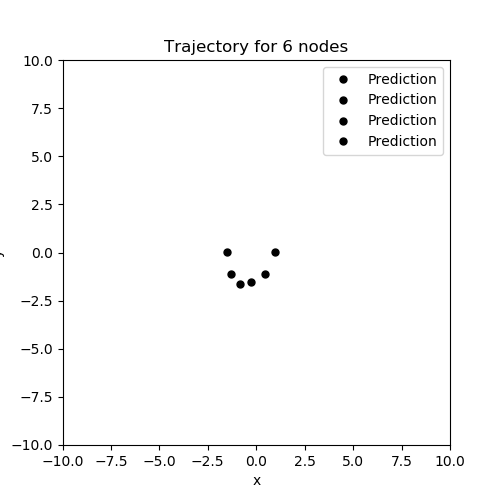

In [44]:
# Visualize trajectories
plt.close('all')
fig_animate3 = plt.figure(1, figsize=(5, 5))
ax3 = fig_animate3.add_subplot(1, 1, 1)

# Visualize trajectories for number_of_masses = 6
#dots = []
dots1 = []

num_nodes = predicted_nodes_rollout_6_np.shape[1]
    
def init():
    for i in range(num_nodes):
        if(i==0):
            #dots.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="r",label="Truth"))
            dots1.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="k",label="Prediction"))
        else:
            #dots.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="r"))
            dots1.append(ax3.plot([], [], linestyle='none', marker='o', markersize=5, color="k"))
    return dots1#, dots,
    
ax3.set_xlim(-10, 10)
ax3.set_ylim(-10, 10)


def animate(z):
    for i in range(num_nodes):
        #dots[i][0].set_data(true_trajectory_9_np[z,i,0],true_trajectory_9_np[z,i,1])
        dots1[i][0].set_data(predicted_nodes_rollout_6_np[z,i,0],predicted_nodes_rollout_6_np[z,i,1])
    legend = ax3.legend()
    return  dots1, legend#, dots



anim = animation.FuncAnimation(fig_animate3, animate,init_func = init, interval = step_size * 1000, frames=num_time_steps, blit=False, repeat=True)
#Save animation
if os.path.exists(os.path.join(path_animations,desc,"FullRollout","trajectory_6_masses.gif")):
    print("The file: "+ "trajectory_6_masses.gif" + "already exists. Delete it before saving a new animation!")
else:
    if not os.path.exists(os.path.join(path_animations, desc)):
        os.mkdir(os.path.join(path_animations, desc))
        if not os.path.exists(os.path.join(path_animations, desc,"FullRollout")):
            os.mkdir(os.path.join(path_animations, desc,"FullRollout"))
    anim.save('Animations/'+desc+'/FullRollout/trajectory_6_masses.gif', writer='imagemagick', fps=20)

ax3.set_title("Trajectory for 6 nodes")
ax3.set_xlabel("x")
ax3.set_ylabel("y")
plt.show()